In [ ]:
!pip install shap pyDOE2
from IPython.core.display import display, HTML
import regex as re
import lightgbm
import pandas as pd
import shap
import sklearn

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb

Patch to match style consistency

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shap import Explanation
from shap.utils import format_value
from shap.plots import colors
from shap.plots._labels import labels

plt.rcParams['figure.dpi'] = 300

# TODO: If we make a JS version of this plot then we could let users click on a bar and then see the dependence
# plot that is associated with that feature get overlaid on the plot...it would quickly allow users to answer
# why a feature is pushing down or up. Perhaps the best way to do this would be with an ICE plot hanging off
# of the bar...
def patch_waterfall(shap_values, max_display=10, show=True):
    """Plots an explanation of a single prediction as a waterfall plot.

    The SHAP value of a feature represents the impact of the evidence provided by that feature on the model's
    output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature
    move the model output from our prior expectation under the background data distribution, to the final model
    prediction given the evidence of all the features.

    Features are sorted by the magnitude of their SHAP values with the smallest
    magnitude features grouped together at the bottom of the plot when the number of
    features in the models exceeds the ``max_display`` parameter.

    Parameters
    ----------
    shap_values : Explanation
        A one-dimensional :class:`.Explanation` object that contains the feature values and SHAP values to plot.

    max_display : str
        The maximum number of features to plot (default is 10).

    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the plot to be customized further after it
        has been created, returning the current axis via plt.gca().

    Examples
    --------

    See `waterfall plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html>`_.

    """

    # Turn off interactive plot
    #if show is False:
    #    plt.ioff()

    # make sure the input is an Explanation object
    if not isinstance(shap_values, Explanation):
        emsg = (
            "The waterfall plot requires an `Explanation` object as the "
            "`shap_values` argument."
        )
        raise TypeError(emsg)

    # make sure we only have a single explanation to plot
    sv_shape = shap_values.shape
    if len(sv_shape) != 1:
        emsg = (
            "The waterfall plot can currently only plot a single explanation, but a "
            f"matrix of explanations (shape {sv_shape}) was passed! Perhaps try "
            "`shap.plots.waterfall(shap_values[0])` or for multi-output models, "
            "try `shap.plots.waterfall(shap_values[0, 0])`."
        )
        raise ValueError(emsg)

    base_values = float(shap_values.base_values)
    features = shap_values.display_data if shap_values.display_data is not None else shap_values.data
    feature_names = shap_values.feature_names
    lower_bounds = getattr(shap_values, "lower_bounds", None)
    upper_bounds = getattr(shap_values, "upper_bounds", None)
    values = shap_values.values

    # unwrap pandas series
    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # fallback feature names
    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(values))])

    # init variables we use for tracking the plot locations
    num_features = min(max_display, len(values))
    row_height = 0.5
    rng = range(num_features - 1, -1, -1)
    order = np.argsort(-np.abs(values))
    pos_lefts = []
    pos_inds = []
    pos_widths = []
    pos_low = []
    pos_high = []
    neg_lefts = []
    neg_inds = []
    neg_widths = []
    neg_low = []
    neg_high = []
    loc = base_values + values.sum()
    yticklabels = ["" for _ in range(num_features + 1)]

    # size the plot based on how many features we are plotting
    plt.gcf().set_size_inches(8, num_features * row_height + 1.5)

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features == len(values):
        num_individual = num_features
    else:
        num_individual = num_features - 1

    # compute the locations of the individual features and plot the dashed connecting lines
    for i in range(num_individual):
        sval = values[order[i]]
        loc -= sval
        if sval >= 0:
            pos_inds.append(rng[i])
            pos_widths.append(sval)
            if lower_bounds is not None:
                pos_low.append(lower_bounds[order[i]])
                pos_high.append(upper_bounds[order[i]])
            pos_lefts.append(loc)
        else:
            neg_inds.append(rng[i])
            neg_widths.append(sval)
            if lower_bounds is not None:
                neg_low.append(lower_bounds[order[i]])
                neg_high.append(upper_bounds[order[i]])
            neg_lefts.append(loc)
        if num_individual != num_features or i + 4 < num_individual:
            plt.plot([loc, loc], [rng[i] - 1 - 0.4, rng[i] + 0.4],
                     color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
        if features is None:
            yticklabels[rng[i]] = feature_names[order[i]]
        else:
            if np.issubdtype(type(features[order[i]]), np.number):
                yticklabels[rng[i]] = format_value(float(features[order[i]]), "%0.03f") + " = " + feature_names[order[i]]
            else:
                yticklabels[rng[i]] = str(features[order[i]]) + " = " + str(feature_names[order[i]])

    # add a last grouped feature to represent the impact of all the features we didn't show
    if num_features < len(values):
        yticklabels[0] = "%d other features" % (len(values) - num_features + 1)
        remaining_impact = base_values - loc
        if remaining_impact < 0:
            pos_inds.append(0)
            pos_widths.append(-remaining_impact)
            pos_lefts.append(loc + remaining_impact)
        else:
            neg_inds.append(0)
            neg_widths.append(-remaining_impact)
            neg_lefts.append(loc + remaining_impact)

    points = pos_lefts + list(np.array(pos_lefts) + np.array(pos_widths)) + neg_lefts + \
        list(np.array(neg_lefts) + np.array(neg_widths))
    dataw = np.max(points) - np.min(points)

    # draw invisible bars just for sizing the axes
    label_padding = np.array([0.1*dataw if w < 1 else 0 for w in pos_widths])
    plt.barh(pos_inds, np.array(pos_widths) + label_padding + 0.02*dataw,
             left=np.array(pos_lefts) - 0.01*dataw, color=colors.red_rgb, alpha=0)
    label_padding = np.array([-0.1*dataw if -w < 1 else 0 for w in neg_widths])
    plt.barh(neg_inds, np.array(neg_widths) + label_padding - 0.02*dataw,
             left=np.array(neg_lefts) + 0.01*dataw, color=colors.blue_rgb, alpha=0)

    # define variable we need for plotting the arrows
    head_length = 0.08
    bar_width = 0.8
    xlen = plt.xlim()[1] - plt.xlim()[0]
    fig = plt.gcf()
    ax = plt.gca()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen/width
    hl_scaled = bbox_to_xscale * head_length
    renderer = fig.canvas.get_renderer()

    # draw the positive arrows
    for i in range(len(pos_inds)):
        dist = pos_widths[i]
        arrow_obj = plt.arrow(
            pos_lefts[i], pos_inds[i], max(dist-hl_scaled, 0.000001), 0,
            head_length=min(dist, hl_scaled),
            color=colors.red_rgb, width=bar_width,
            head_width=bar_width,
        )

        if pos_low is not None and i < len(pos_low):
            plt.errorbar(
                pos_lefts[i] + pos_widths[i], pos_inds[i],
                xerr=np.array([[pos_widths[i] - pos_low[i]], [pos_high[i] - pos_widths[i]]]),
                ecolor=colors.light_red_rgb,
            )

        txt_obj = plt.text(
            pos_lefts[i] + 0.5*dist, pos_inds[i], format_value(pos_widths[i], '%+0.02f'),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=12,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width:
            txt_obj.remove()

            txt_obj = plt.text(
                pos_lefts[i] + (5/72)*bbox_to_xscale + dist, pos_inds[i], format_value(pos_widths[i], '%+0.02f'),
                horizontalalignment='left', verticalalignment='center', color=colors.red_rgb,
                fontsize=12,
            )

    # draw the negative arrows
    for i in range(len(neg_inds)):
        dist = neg_widths[i]

        arrow_obj = plt.arrow(
            neg_lefts[i], neg_inds[i], -max(-dist-hl_scaled, 0.000001), 0,
            head_length=min(-dist, hl_scaled),
            color=colors.blue_rgb, width=bar_width,
            head_width=bar_width,
        )

        if neg_low is not None and i < len(neg_low):
            plt.errorbar(
                neg_lefts[i] + neg_widths[i], neg_inds[i],
                xerr=np.array([[neg_widths[i] - neg_low[i]], [neg_high[i] - neg_widths[i]]]),
                ecolor=colors.light_blue_rgb,
            )

        txt_obj = plt.text(
            neg_lefts[i] + 0.5*dist, neg_inds[i], format_value(neg_widths[i], '%+0.02f'),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=12,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width:
            txt_obj.remove()

            txt_obj = plt.text(
                neg_lefts[i] - (5/72)*bbox_to_xscale + dist, neg_inds[i], format_value(neg_widths[i], '%+0.02f'),
                horizontalalignment='right', verticalalignment='center', color=colors.blue_rgb,
                fontsize=12,
            )

    # draw the y-ticks twice, once in gray and then again with just the feature names in black
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ytick_pos = list(range(num_features)) + list(np.arange(num_features)+1e-8)
    plt.yticks(ytick_pos, yticklabels[:-1] + [label.split('=')[-1] for label in yticklabels[:-1]], fontsize=13)

    # put horizontal lines for each feature row
    for i in range(num_features):
        plt.axhline(i, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

    # mark the prior expected value and the model prediction
    plt.axvline(base_values, 0, 1/num_features, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
    fx = base_values + values.sum()
    plt.axvline(fx, 0, 1, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)

    # clean up the main axis
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    ax.tick_params(labelsize=13)
    #plt.xlabel("\nModel output", fontsize=12)

    #ax.set_xlim(0.00,1.00)

    # draw the E[f(X)] tick mark
    xmin, xmax = ax.get_xlim()
    ax2 = ax.twiny()
    ax2.set_xlim(xmin, xmax)
    #ax2.set_xlim(0.00,1.00)
    ax2.set_xticks([base_values, base_values+1e-8])  # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax2.set_xticklabels(["\n$base$ $value$", "\n\t $ =  "+format_value(base_values, "%0.03f")+"$"], fontsize=12, ha="center")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # draw the f(x) tick mark
    ax3 = ax2.twiny()
    ax3.set_xlim(xmin, xmax)
    #ax3.set_xlim(0.00,1.00)
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax3.set_xticks([base_values + values.sum(), base_values + values.sum() + 1e-8])#e-8]) #ZHANNA CHANGED
    ax3.set_xticklabels(["$prediction$", "\t\t $  = $"+ "$" + format_value(fx, "%0.03f")+"$"], fontsize=12, ha="center")
    tick_labels = ax3.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(-10/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(12/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_color("#999999")
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # adjust the position of the E[f(X)] = x.xx label
    tick_labels = ax2.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(-20/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(22/72., -1/72., fig.dpi_scale_trans))

    tick_labels[1].set_color("#999999")

    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color("#999999")

    if show:
        plt.show()
    else:
        return plt.gca()
shap.plots.waterfall = patch_waterfall

Set up tutorial examples

Start by training the "should you bring an umbrella?" model

In [ ]:
preX = pd.read_csv("Umbrella.csv")
preX = preX.sample(frac=1)
X_display = preX.iloc[:,:-1]
y_display = preX.iloc[:,-1]

PRECIPITATION = {
    "none": 0,
    "drizzle": 1,
    "rain": 2,
    "snow": 3,
    "sleet": 4,
    "hail": 5
}

y = y_display
X = X_display
X = X.replace({"Precipitation":PRECIPITATION})

X_train = X.iloc[:300]
y_train = y.iloc[:300]

X_test = X.iloc[300:]
y_test = y.iloc[300:]

d_train = lightgbm.Dataset(X_train, label=y_train)
d_test = lightgbm.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "keep_training_booster": True
}

#model = lgb.train(params, d_train, 10000, valid_sets=[d_test]) #early_stopping_rounds=50, verbose_eval=1000
model = lightgbm.LGBMClassifier(max_bin= 512,
    learning_rate= 0.05,
    boosting_type= "gbdt",
    objective= "binary",
    metric= "binary_logloss",
    num_leaves= 10,
    verbose= -1,
    min_data= 100,
    boost_from_average= True)
model.fit(X_train, y_train)

<ipython-input-8-59731d8556ad>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({"Precipitation":PRECIPITATION})


LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='binary_logloss', min_data=100, num_leaves=10,
               objective='binary', verbose=-1)

Find the location of one of the two tutorial examples

In [ ]:
print(X.loc[(X['Precipitation'] == 5) & (X['Temperature'] == 23) & (X['Wind(mph)'] == 10)])
print(X.loc[(X['Precipitation'] == 0) & (X['Temperature'] == 70) & (X['Wind(mph)'] == 30)])
theloc = X.index.get_loc(330)

     Precipitation  Temperature  Wind(mph)
330              5           23         10
    Precipitation  Temperature  Wind(mph)
96              0           70         30


Generate a tutorial explanation

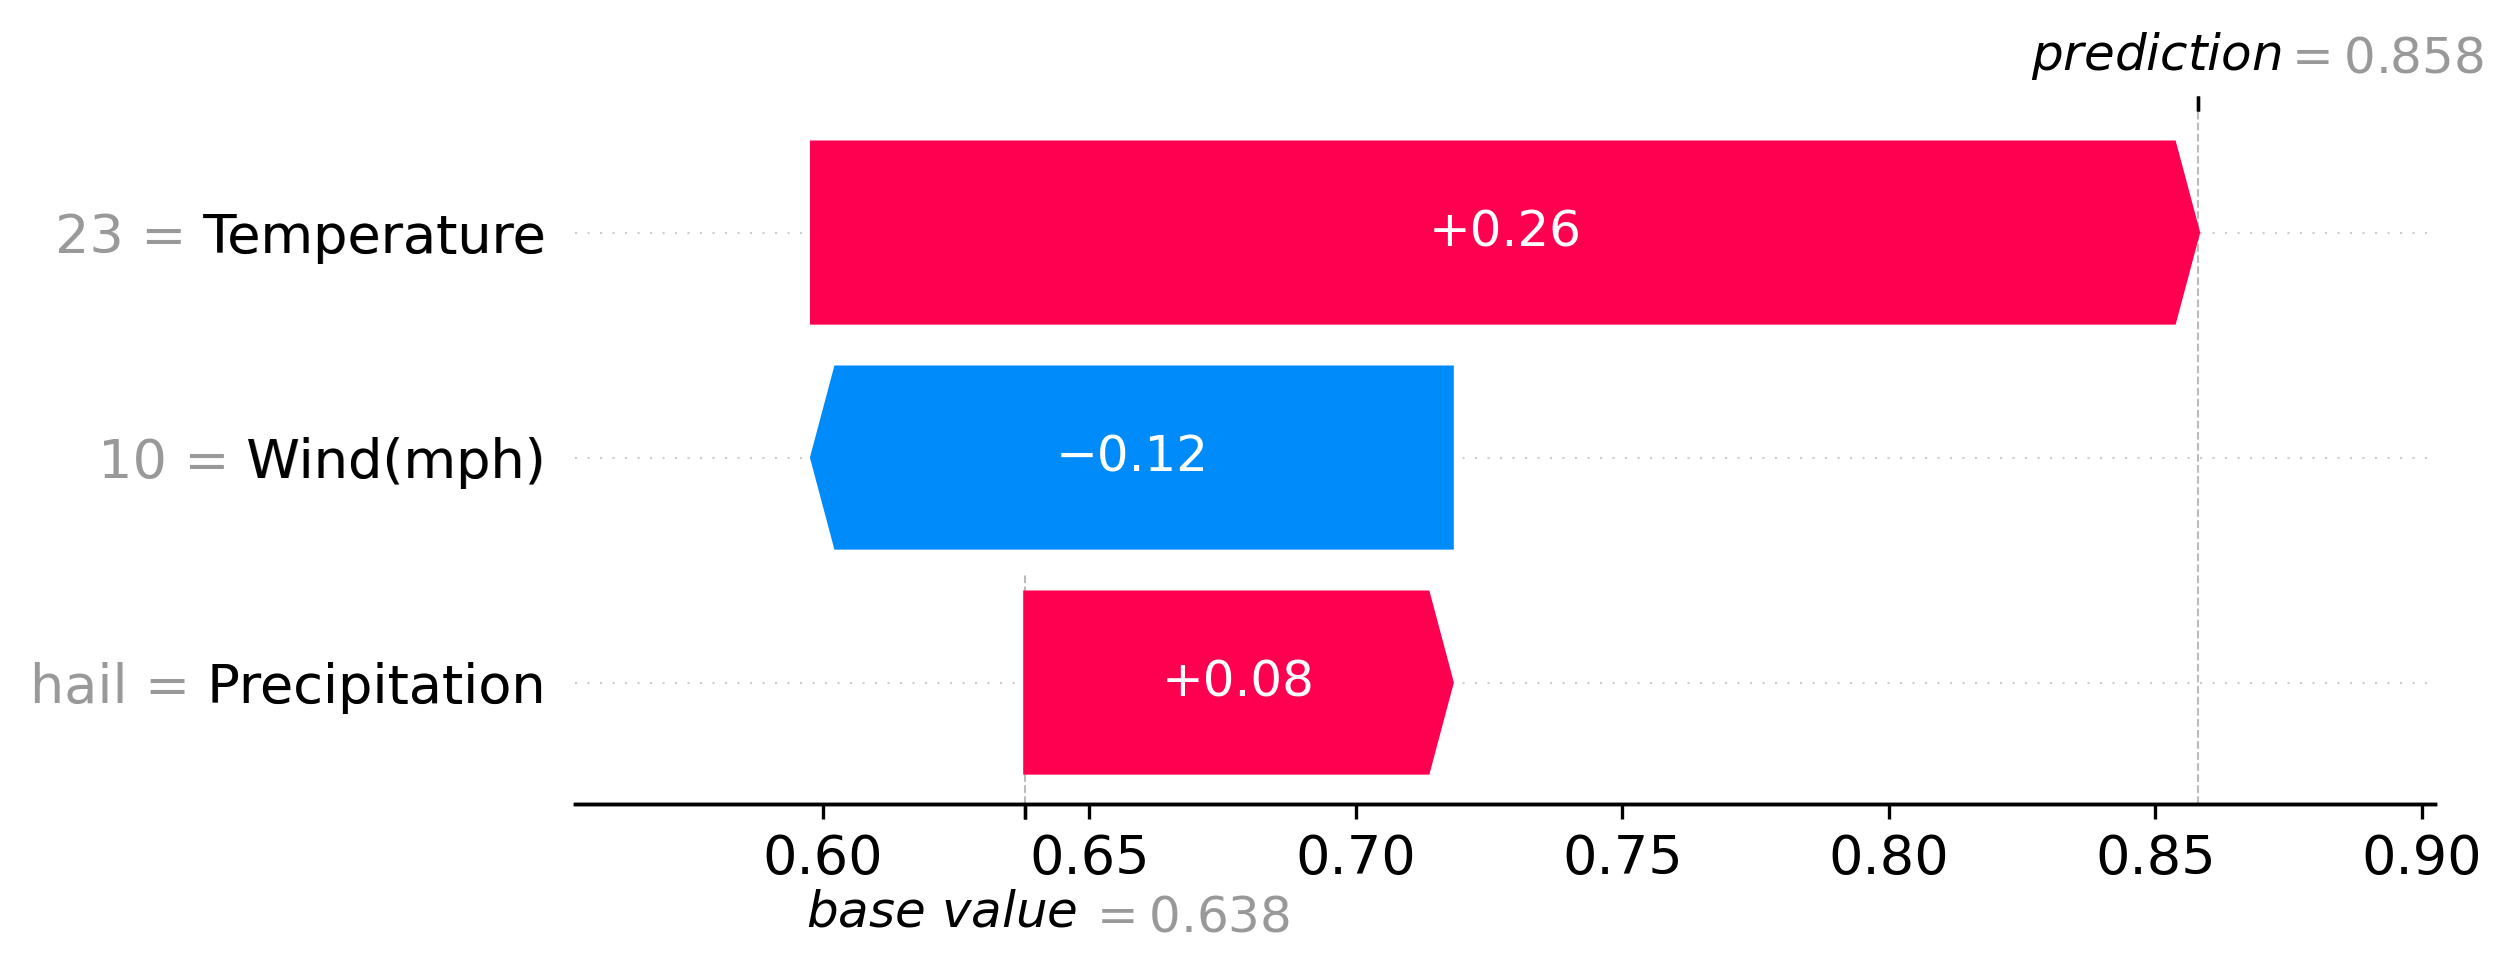

In [ ]:
explainer = shap.Explainer(model, X, model_output="probability")
#shap_values = explainer(X)
mynewexp = shap._explanation.Explanation(values=np.array([0.08, 0.26, -0.12]), base_values = 0.638, data =  X_display.iloc[theloc,:])

shap.plots.waterfall(mynewexp, max_display=20)

#Loan Instances

Edit and prepare dataset

In [ ]:
# load dataset
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

EDUCATION_NUM = {
    16.0: "Doctorate",
    15.0: "Prof. School",
    14.0: "Masters",
    13.0: "Bachelors",
    12.0: "Some College",
    11.0: "Associate", #Assoc-acdm
    10.0: "Vocational", #Assoc-voc
    9.0: "HS grad",
    8.0: "12th",
    7.0: "11th",
    6.0: "10th",
    5.0: "9th",
    4.0: "7th-8th",
    3.0: "5th-6th",
    2.0: "1st-4th",
    1.0: "Preschool"
}

OCCUPATION_NUM = {
    "Tech-support": "Tech Support",
    "Craft-repair": "Craft/Repair",
    "Other-service": "Other Service",
    "Sales": "Sales",
    "Exec-managerial": "Exec. Managerial",
    "Prof-specialty": "Prof. Specialty",
    "Handlers-cleaners": "Handler/Cleaner",
    "Machine-op-inspct": "Machine Op. Inspector",
    "Adm-clerical": "Admin. Clerical",
    "Farming-fishing": "Farming/Fishing",
    "Transport-moving": "Transport/Moving",
    "Priv-house-serv": "Private House Service",
    "Protective-serv": "Protective Service",
    "Armed-Forces": "Armed Forces"

}
X_display = X_display.replace({"Education-Num":EDUCATION_NUM})
X_display = X_display.replace({"Occupation":OCCUPATION_NUM})
X = X.rename(columns={"Education-Num": "Education"})
X_display = X_display.rename(columns={"Education-Num": "Education"})#, "Hours per week": "Hours worked per week"})

X = X.drop(['Capital Loss', 'Capital Gain', 'Race', 'Relationship', 'Country', 'Workclass', 'Marital Status'], axis=1)
X_display = X_display.drop(['Capital Loss', 'Capital Gain', 'Race', 'Relationship', 'Country', 'Workclass', 'Marital Status'], axis=1)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

Train the model

In [ ]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    'objective':'multi:softprob',
    "boost_from_average": True
}

params_xgb={
    'base_score':0.5,
    'learning_rate':0.05,
    'max_depth':5,
    'min_child_weight':100,
    'n_estimators':200,
    'num_class': 2,
    'nthread':-1,
    'objective':'multi:softprob',
    'seed':2018,
    'eval_metric':'auc'
}

model = lgb.LGBMClassifier(max_bin= 512,
    learning_rate= 0.05,
    boosting_type= "gbdt",
    objective= "binary",
    metric= "binary_logloss",
    num_leaves= 10,
    verbose= -1,
    min_data= 100,
    boost_from_average= True)
model.fit(X_train, y_train)

LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='binary_logloss', min_data=100, num_leaves=10,
               objective='binary', verbose=-1)

Our 7 loan application instances

In [ ]:
#val = 610 # Woman Side-by-side
#val = 11116 # Man Side-by-side
#val = 32353 # Man 3
#val = 217 # Man 2
#val = 15040 # Man 1
#val = 32429 # Woman 3
val = 32556 # Woman 2
#val = 91#91 # Woman 1

theloc = val

Generate SHAP Explanation

In [ ]:
explainer = shap.Explainer(model, X, model_output="probability")
shap_values = explainer(X)

100%|===================| 32418/32561 [01:47<00:00]       

<ipython-input-7-465cce54bdf2>:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
<ipython-input-7-465cce54bdf2>:140: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.issubdtype(type(features[order[i]]), np.number):
<ipython-input-7-465cce54bdf2>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yticklabels[rng[i]] = format_value(float(features[order[i]]), "%0.03f") + " = " + feature_names[order[i]]
<ipyt

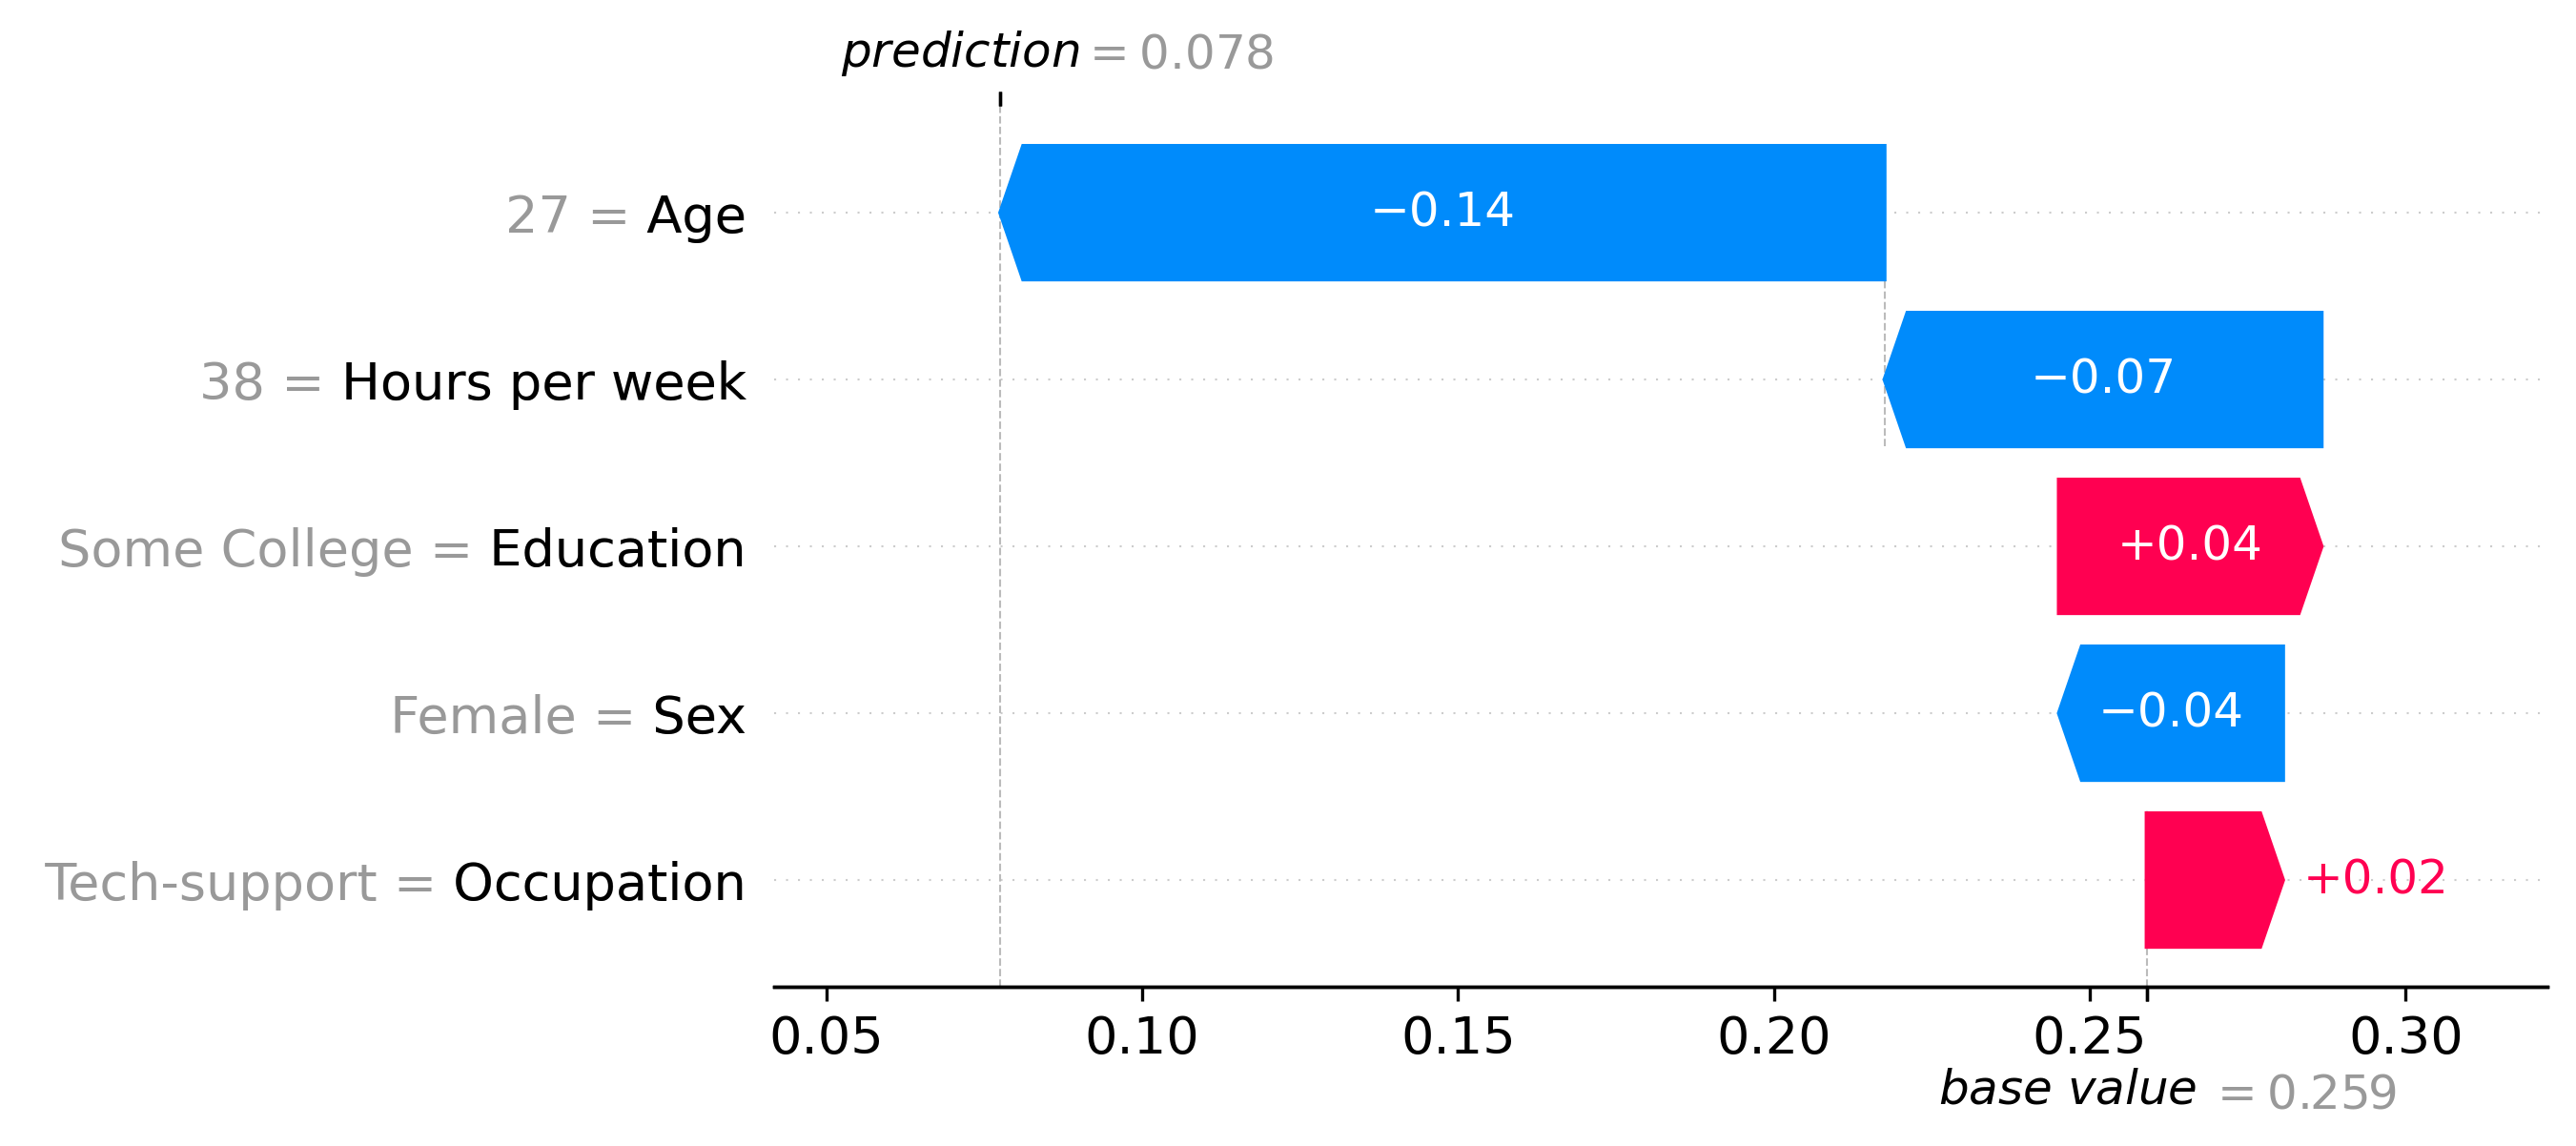

In [ ]:
#shap_values_standin0 = pd.Series({'Age': 0.0307, 'Education': -0.0287, 'Occupation': -0.0026, 'Sex': -0.1075, 'Hours per week': -0.0351}) # Woman 1
shap_values_standin0 = pd.Series({'Age': -0.14, 'Education': 0.0416, 'Occupation':  0.0216, 'Sex': -0.0355, 'Hours per week':  -0.0692}) # Woman 2
#shap_values_standin0 = pd.Series({'Age': 0.1209, 'Education': 0.3008, 'Occupation': 0.0317, 'Sex': -0.0766, 'Hours per week':  0.0115}) # Woman 3
#shap_values_standin0 = pd.Series({'Age': -0.2119, 'Education': 0.0011, 'Occupation': 0.0171,'Sex': 0.0096, 'Hours per week':  -0.0149}) # Man 1
#shap_values_standin0 = pd.Series({'Age': 0.0565, 'Education': 0.1427, 'Occupation': 0.0507, 'Sex': 0.0854, 'Hours per week':  0.0756}) # Man 2
#shap_values_standin0 = pd.Series({'Age': -0.0012, 'Education': -0.189, 'Occupation': 0.0022, 'Sex': 0.0448, 'Hours per week':  0.0256}) # Man 3
#shap_values_standin0 = pd.Series({'Age': 0.0774, 'Education': 0.1962, 'Occupation': 0.0318, 'Sex': 0.106, 'Hours per week':  0.0741}) # Man Fair
#shap_values_standin0 = pd.Series({'Age': 0.0668, 'Education': 0.1619, 'Occupation': 0.0297,'Sex': -0.1366, 'Hours per week':  0.0318}) # Woman Fair

mynewexp = shap._explanation.Explanation(values=shap_values_standin0, base_values = 0.259, data =  X_display.iloc[theloc,:])

shap.plots.waterfall(mynewexp, max_display=20)
